## 1. Introduction

Melanoma is a severe type of skin cancer that can be fatal if not detected early.
Early and accurate detection of melanoma can significantly improve patient outcomes.
This project aims to develop a deep learning model using convolutional neural network with traditional machine learning algorithms for handling patient-specific factors that can accurately classify images of skin lesions as either malignant (melanoma) or benign.


## 2. Exploratory Data Analysis

In [38]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Concatenate, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback, LambdaCallback
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from PIL import Image
import psutil
import os
import time
import gc
import math
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt



In [2]:
# Import data
train_df = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/train.csv')
test_df = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/test.csv')

In [3]:
# Display data types of each column
print(train_df.dtypes)

image_name                        object
patient_id                        object
sex                               object
age_approx                       float64
anatom_site_general_challenge     object
diagnosis                         object
benign_malignant                  object
target                             int64
dtype: object


In [4]:
# Select the first 10 rows and display the patient-specific factors
patient_factors = train_df.head(50000)
print(patient_factors)

         image_name  patient_id     sex  age_approx  \
0      ISIC_2637011  IP_7279968    male        45.0   
1      ISIC_0015719  IP_3075186  female        45.0   
2      ISIC_0052212  IP_2842074  female        50.0   
3      ISIC_0068279  IP_6890425  female        45.0   
4      ISIC_0074268  IP_8723313  female        55.0   
...             ...         ...     ...         ...   
33121  ISIC_9999134  IP_6526534    male        50.0   
33122  ISIC_9999320  IP_3650745    male        65.0   
33123  ISIC_9999515  IP_2026598    male        20.0   
33124  ISIC_9999666  IP_7702038    male        50.0   
33125  ISIC_9999806  IP_0046310    male        45.0   

      anatom_site_general_challenge diagnosis benign_malignant  target  
0                         head/neck   unknown           benign       0  
1                   upper extremity   unknown           benign       0  
2                   lower extremity     nevus           benign       0  
3                         head/neck   unknown  

In [5]:
#Short summary, with some data showing as NaN cause they exist as objects
print(patient_factors.describe(include='all'))

          image_name  patient_id    sex    age_approx  \
count          33126       33126  33061  33058.000000   
unique         33126        2056      2           NaN   
top     ISIC_9999806  IP_4479736   male           NaN   
freq               1         115  17080           NaN   
mean             NaN         NaN    NaN     48.870016   
std              NaN         NaN    NaN     14.380360   
min              NaN         NaN    NaN      0.000000   
25%              NaN         NaN    NaN     40.000000   
50%              NaN         NaN    NaN     50.000000   
75%              NaN         NaN    NaN     60.000000   
max              NaN         NaN    NaN     90.000000   

       anatom_site_general_challenge diagnosis benign_malignant        target  
count                          32599     33126            33126  33126.000000  
unique                             6         9                2           NaN  
top                            torso   unknown           benign           N

In [6]:
# Count the number of malignant and benign cases
malignant_count = train_df[train_df['target'] == 1].shape[0]
benign_count = train_df[train_df['target'] == 0].shape[0]

print(f'Malignant cases: {malignant_count}')
print(f'Benign cases: {benign_count}')

Malignant cases: 584
Benign cases: 32542


In [7]:
# Interactive histogram for Diagnosis (target)
fig1 = px.histogram(train_df, x='target', title='Diagnosis Distribution (0 = Benign, 1 = Malignant)', 
                    labels={'target': 'Diagnosis'}, category_orders={"target": [0, 1]})
fig1.update_traces(marker_line_width=1, marker_line_color="black")
fig1.update_layout(yaxis=dict(tickmode='array', tickvals=[0, 1], ticktext=['0', '1']))
fig1.show()

# Interactive histogram for Sex
fig2 = px.histogram(train_df, x='sex', title='Sex Distribution', 
                    labels={'sex': 'Sex'}, nbins=30)
fig2.update_traces(marker_line_width=1, marker_line_color="black")
fig2.show()

# Interactive histogram for Age Approximation
fig3 = px.histogram(train_df, x='age_approx', title='Age Approximation Distribution', 
                    labels={'age_approx': 'Age Approximation'}, nbins=30)
fig3.update_traces(marker_line_width=1, marker_line_color="black")
fig3.show()

# Interactive histogram for Anatomical Site
fig4 = px.histogram(train_df, x='anatom_site_general_challenge', title='Anatomical Site Distribution', 
                    labels={'anatom_site_general_challenge': 'Anatomical Site'}, nbins=30)
fig4.update_traces(marker_line_width=1, marker_line_color="black")
fig4.show()


## 3. Observation

From the distribution in diagnosis, it looks like there is a large number of benign diagnosis compared to malignant. I will be looking into balancing the weight later during the training to avoid over representation of the bengin data. 

As for the sex, there seems to be a relatively equal number of male and female within the training data which seems to be acceptable. There are only slightly more men than women.

For the age distribution, it looks like a normal distribution curve with the peaks at around 45 and 50 years of age. There is also a slight skew to the right. This  is expected as there would be a higher occurance of cancer in the older population.

As for the the anatomical site, torso represents the highest proportion in the data. This should not come as a surprise as the torso takes up approximately 1/3 of the entire surface area. As such, with a higher surface area, there should be a higher likelihood of melanoma occuring.

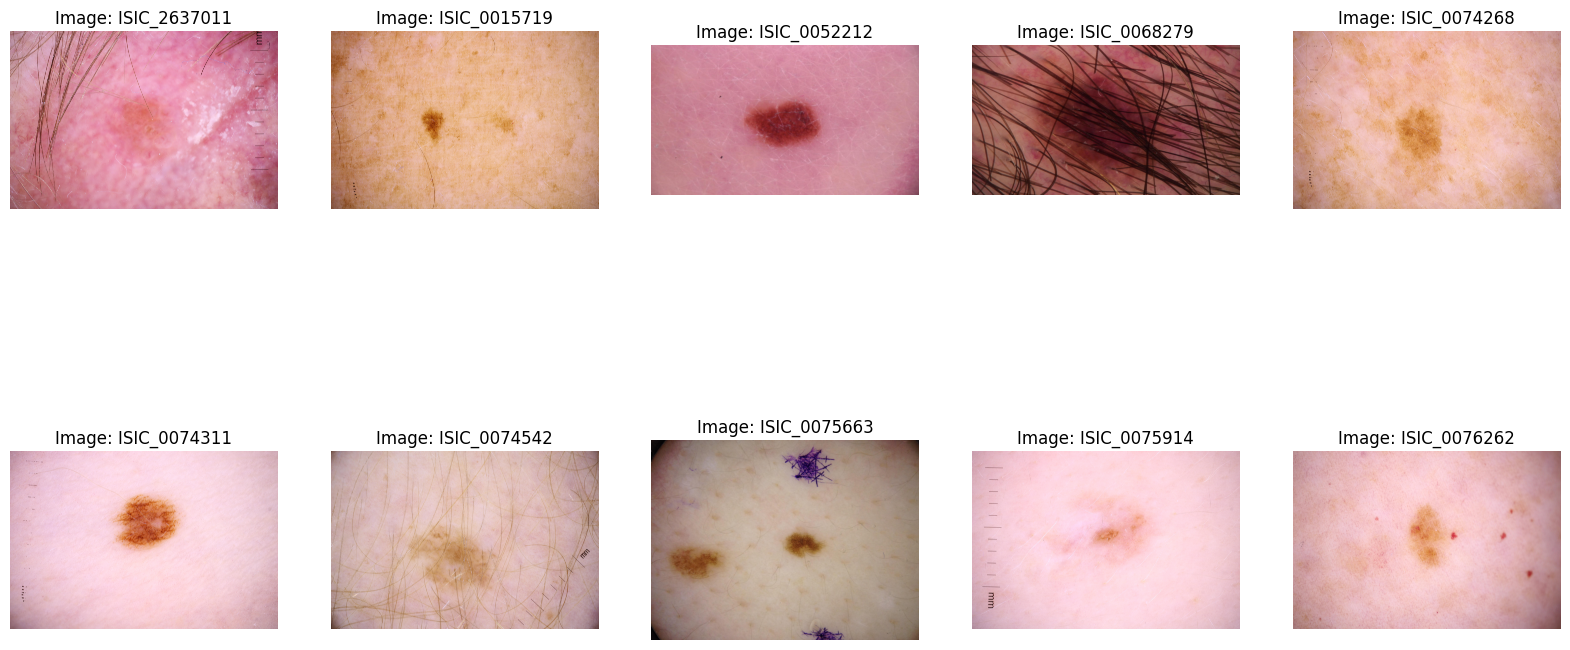

In [8]:
# Define the directory where the images are stored
img_dir = '/kaggle/input/siim-isic-melanoma-classification/jpeg/train'

# Get the first 10 image file names
image_files = train_df['image_name'].head(10).apply(lambda x: os.path.join(img_dir, f'{x}.jpg'))

# Plot the first 10 images
plt.figure(figsize=(20, 10))
for i, img_path in enumerate(image_files):
    img = Image.open(img_path)
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f'Image: {train_df["image_name"].iloc[i]}')
    plt.axis('off')
plt.show()


## 4. Preparation of Data

Now that I have done some exploration and viewing of the data and images respectively, I will go on with the formatting of the data to prepare it for processing later.

In [9]:
# Formatting data
# Map 'sex' to binary values: male -> 1, female -> 0
train_df['sex'] = train_df['sex'].map({'male': 1, 'female': 0})
test_df['sex'] = test_df['sex'].map({'male': 1, 'female': 0})


In [10]:
# Fill missing values with 'unknown'
train_df['anatom_site_general_challenge'] = train_df['anatom_site_general_challenge'].fillna('unknown')
test_df['anatom_site_general_challenge'] = test_df['anatom_site_general_challenge'].fillna('unknown')

# Convert all values in 'anatom_site_general_challenge' and 'sex' to strings
train_df['anatom_site_general_challenge'] = train_df['anatom_site_general_challenge'].astype(str)
test_df['anatom_site_general_challenge'] = test_df['anatom_site_general_challenge'].astype(str)

# Encode 'anatom_site_general_challenge' column
le_anatom_site = LabelEncoder()
train_df['anatom_site_general_challenge'] = le_anatom_site.fit_transform(train_df['anatom_site_general_challenge'])
test_df['anatom_site_general_challenge'] = le_anatom_site.transform(test_df['anatom_site_general_challenge'])

In [11]:
# Convert 'target' to float
train_df['target'] = train_df['target'].astype(float)

In [12]:
# Display rows with any NaNs
nan_rows = train_df[train_df.isna().any(axis=1)]
print(nan_rows)


         image_name  patient_id  sex  age_approx  \
38     ISIC_0088137  IP_5205991  NaN         NaN   
384    ISIC_0229600  IP_5205991  NaN         NaN   
432    ISIC_0239070  IP_0550106  0.0         NaN   
750    ISIC_0331124  IP_9835712  NaN         NaN   
829    ISIC_0353280  IP_9835712  NaN         NaN   
...             ...         ...  ...         ...   
30224  ISIC_9132088  IP_5205991  NaN         NaN   
31338  ISIC_9470153  IP_9835712  NaN         NaN   
31451  ISIC_9501056  IP_9835712  NaN         NaN   
32142  ISIC_9710367  IP_5205991  NaN         NaN   
32610  ISIC_9844508  IP_9835712  NaN         NaN   

       anatom_site_general_challenge diagnosis benign_malignant  target  
38                                 1   unknown           benign     0.0  
384                                6   unknown           benign     0.0  
432                                4     nevus           benign     0.0  
750                                4   unknown           benign     0.0  
829  

In [13]:
#remove NAN cells 
train_df = train_df.dropna()


In [14]:
def create_tf_data_generator(df, img_dir, batch_size=32, target_size=(128, 128), is_train=True):
    def load_data(row):
        img_path = tf.strings.join([img_dir, '/', row['image_name'], '.jpg'])
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, target_size)
        img = img / 255.0
        patient_data = tf.stack([
            tf.cast(row['sex'], tf.float32),
            tf.cast(row['age_approx'], tf.float32),
            tf.cast(row['anatom_site_general_challenge'], tf.float32)
        ], axis=-1)
        return img, patient_data

    def load_data_with_labels(row):
        img, patient_data = load_data(row)
        label = tf.cast(row['target'], tf.float32)
        return (img, patient_data), label

    dataset = tf.data.Dataset.from_tensor_slices(dict(df))
    if is_train:
        dataset = dataset.shuffle(buffer_size=len(df))
    dataset = dataset.map(load_data_with_labels, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset


In [15]:
# Create data generators
train_generator = create_tf_data_generator(train_df, img_dir='/kaggle/input/siim-isic-melanoma-classification/jpeg/train', is_train=True)
val_generator = create_tf_data_generator(train_df.sample(frac=0.2, random_state=42), img_dir='/kaggle/input/siim-isic-melanoma-classification/jpeg/train', is_train=False)


In [16]:
# Define the directory containing the test images
test_img_dir = '/kaggle/input/siim-isic-melanoma-classification/jpeg/test'

# Filter test_df to include only the image files that exist in the directory
existing_files = os.listdir(test_img_dir)
test_df = test_df[test_df['image_name'].apply(lambda x: f'{x}.jpg' in existing_files)]

def create_tf_test_data_generator(df, img_dir, batch_size=32, target_size=(128, 128)):
    def load_data(row):
        img_path = tf.strings.join([img_dir, '/', row['image_name'], '.jpg'])
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, target_size)
        img = img / 255.0
        patient_data = tf.stack([
            tf.cast(row['sex'], tf.float32),
            tf.cast(row['age_approx'], tf.float32),
            tf.cast(row['anatom_site_general_challenge'], tf.float32)
        ], axis=-1)
        return img, patient_data

    def load_data_no_labels(row):
        img, patient_data = load_data(row)
        return img, patient_data

    dataset = tf.data.Dataset.from_tensor_slices(dict(df))
    dataset = dataset.map(load_data_no_labels, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset


In [17]:
# Create test data generator
test_generator = create_tf_test_data_generator(test_df, img_dir=test_img_dir)

# Generate predictions
test_images, test_patient_data = [], []
for batch in test_generator:
    images, patient_data = batch
    test_images.append(images)
    test_patient_data.append(patient_data)

test_images = tf.concat(test_images, axis=0)
test_patient_data = tf.concat(test_patient_data, axis=0)

## 5. Model Architecture

### Image Input and Feature Extraction
The image input layer accepts 128x128 pixel images with 3 color channels which are RGB. For feature extraction from these images, I used a pre-trained EfficientNetB0 model. EfficientNetB0, trained on the ImageNet dataset, helps me utilise a convolutional neural network for extracting rich feature maps from the images. To convert these feature maps into a 1D tensor of features, I also applied global average pooling. This pooling layer is followed by a dropout layer, which helps in regularising the model by randomly setting a fraction of input units to zero during each update of the training phase.

### Patient Data Input and Processing
Besides the image input, my model also takes patient-specific data, including sex, age, and anatomical site of the lesion. This data is processed through a series of connected layers that apply linear transformations and ReLU activation functions. Dropout layers are incorporated between these fully connected layers to prevent overfitting. Additionally, L2 regularization is applied to the weights of these layers to further enhance the model's generalization capability.

### Combining Image and Patient Data Features
Once the features from both the image and patient data are extracted, they are concatenated to form a combined feature vector.

### Final Classification Layers
The concatenated features are added to fully connected layers, further refining the combined features. I employed ReLU activation functions and dropout for regularization. The final output layer uses a sigmoid activation function to produce a probability score, indicating the likelihood of a skin lesion being malignant. This score is a single value between 0 and 1, suitable for binary classification.

### Model Compilation
The model is compiled with the Adam optimizer, using binary cross-entropy as the loss function. Accuracy is used as a metric to evaluate the performance of the model during training and testing.


In [18]:
# Define model
image_input = Input(shape=(128, 128, 3))
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=image_input)
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
image_features = Model(inputs=image_input, outputs=x)

# Define patient data input
patient_input = Input(shape=(train_df[['sex', 'age_approx', 'anatom_site_general_challenge']].shape[1],))
y = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(patient_input)
y = Dropout(0.3)(y)
y = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(y)

# Combine image and patient data features
combined = Concatenate()([image_features.output, y])
z = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(combined)
z = Dropout(0.5)(z)
output = Dense(1, activation='sigmoid', dtype=tf.float32)(z)

# Define and compile the model
model = Model(inputs=[image_features.input, patient_input], outputs=output)
optimizer = Adam(learning_rate=1e-5, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## 6. Evaluate the Model after Training

We evaluate the model's performance on the validation data to determine how well it generalizes. This uses the val_generator to determine the mode's accuracy.


In [19]:
# Calculate class weights to balance the benign and malignant data
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['target'].values),
    y=train_df['target'].values
)

class_weights_dict = dict(enumerate(class_weights))
print(f"Class weights: {class_weights_dict}")


Class weights: {0: 0.5089918088316807, 1: 28.30308219178082}


In [20]:
# Function to monitor memory usage
def print_memory_usage():
    process = psutil.Process(os.getpid())
    print(f"Memory Usage: {process.memory_info().rss / 1024 ** 2:.2f} MB")


In [21]:
# Custom callback to log epoch duration and monitor memory
class MemoryCallback(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1} took {time.time() - self.epoch_time_start:.2f} seconds")
        print_memory_usage()
        gc.collect()  # Trigger garbage collection to free up memory

In [22]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)
nan_callback = LambdaCallback(on_epoch_end=check_for_nan)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, mode='min', restore_best_weights=True, verbose=1)
memory_callback = MemoryCallback()

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=20,
    validation_steps=20,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, reduce_lr, memory_callback]
)

# Evaluate the model on the validation data
results = model.evaluate(val_generator, verbose=1)
print(f"Validation Loss: {results[0]}")
print(f"Validation Accuracy: {results[1]}")


Epoch 1/10
 1/20 ━━━━━━━━━━━━━━━━━━━━ 36:14 114s/step - accuracy: 0.5312 - loss: 4.0164

I0000 00:00:1719337707.615440     111 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1719337707.738906     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.5703 - loss: 3.2469

W0000 00:00:1719337731.149129     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 1 took 152.06 seconds
Memory Usage: 8672.86 MB
20/20 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.5707 - loss: 3.2334 - val_accuracy: 0.9797 - val_loss: 2.6680 - learning_rate: 1.0000e-05
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.5876 - loss: 2.8939Epoch 2 took 34.68 seconds
Memory Usage: 8874.18 MB
20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.5887 - loss: 2.9027 - val_accuracy: 0.8609 - val_loss: 2.7269 - learning_rate: 1.0000e-05
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.6318 - loss: 3.1332Epoch 3 took 30.01 seconds
Memory Usage: 8827.14 MB
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.6318 - loss: 3.1473 - val_accuracy: 0.9578 - val_loss: 2.6655 - learning_rate: 1.0000e-05
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.6530 - loss: 3.0629Epoch 4 took 31.83 seconds
Memory Usage: 8905.98 MB
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.6537 - loss: 3.0733 - val_accuracy: 0.9797 - val_loss

High Validation Accuracy: The model demonstrates high validation accuracy throughout the training, suggesting it performs well on the validation set. This is a positive indicator of generalization.

High Loss Values: Despite the high accuracy, both training and validation losses remain relatively high. This discrepancy between accuracy and loss might indicate issues such as:

- Class Imbalance: The dataset is likely imbalanced, as previously noted, with significantly more benign cases than malignant ones. High accuracy can be misleading in such cases, as it may be driven by correctly predicting the majority class (benign).
- Overfitting: The model may have overfitted to the training data, memorizing it rather than learning general patterns. However, given the high validation accuracy, overfitting might not be a primary concern here.

Due to the limited resources and ram, the number of steps per epoch is limited which could have resulted in the higher validation loss.

In [25]:
# Make predictions on test data
test_predictions = model.predict([test_images, test_patient_data], verbose=1)

 13/344 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step

W0000 00:00:1719338557.145033     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


344/344 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step


In [27]:
# Prepare the submission
submission = pd.DataFrame({'image_name': test_df['image_name'],'target': test_predictions.squeeze()})
submission.to_csv('submission.csv', index=False)

In [28]:
submission

,image_name,target
0,ISIC_0052060,0.116434
1,ISIC_0052349,0.054756
2,ISIC_0058510,0.000011
3,ISIC_0073313,0.018250
4,ISIC_0073502,0.000233
...,...,...
10977,ISIC_9992485,0.003587
10978,ISIC_9996992,0.007905
10979,ISIC_9997917,0.101189
10980,ISIC_9998234,0.005563


## 7. Results and Discussion

In [29]:
# Calculate the proportion of predictions
less_than_half = np.sum(test_predictions < 0.5) / len(test_predictions)
more_than_half = np.sum(test_predictions >= 0.5) / len(test_predictions)

print(f'Proportion of predictions less than 0.5: {less_than_half * 100:.2f}%')
print(f'Proportion of predictions more than or equal to 0.5: {more_than_half * 100:.2f}%')


Proportion of predictions less than 0.5: 99.49%
Proportion of predictions more than or equal to 0.5: 0.51%


In [50]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(8, 6))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap=cmap,
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


In [53]:
# Make predictions on the validation data
val_generator = create_tf_data_generator(val_subset_df, img_dir='/kaggle/input/siim-isic-melanoma-classification/jpeg/train', is_train=False)

# Initialize lists for images, patient data, and labels
val_images, val_patient_data, val_labels = [], [], []

# Fetch the data from the generator
for images, patient_data in val_generator:
    val_images.extend(images)
    val_patient_data.extend(patient_data)

# Ensure the lists are numpy arrays
val_images = np.array(val_images)
val_patient_data = np.array(val_patient_data)

# If labels are available in the val_subset_df, get them
if 'target' in val_subset_df.columns:
    val_labels = val_subset_df['target'].values[:len(val_images)]

104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Confusion matrix, without normalization
[[3071  173]
 [  56    6]]


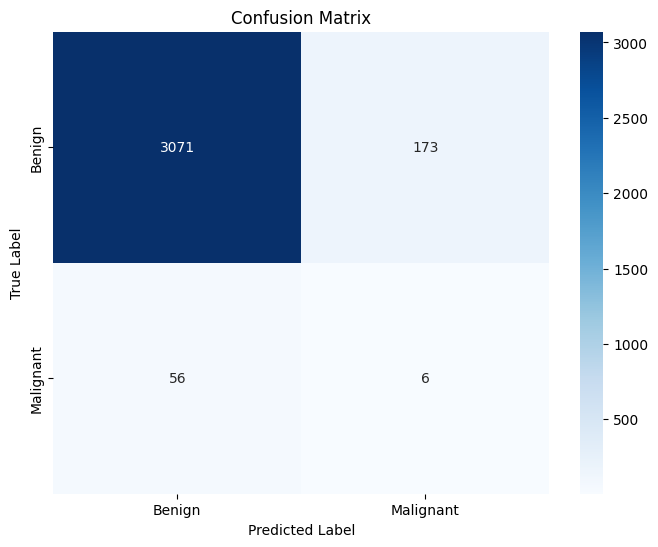

              precision    recall  f1-score   support

      Benign       0.98      0.95      0.96      3244
   Malignant       0.03      0.10      0.05        62

    accuracy                           0.93      3306
   macro avg       0.51      0.52      0.51      3306
weighted avg       0.96      0.93      0.95      3306



In [57]:
# Make predictions
predictions = model.predict([val_images, val_patient_data])
pred_labels = (predictions > 0.1).astype(int)

# Compute confusion matrix
cm = confusion_matrix(val_labels, pred_labels)

# Plot confusion matrix
plot_confusion_matrix(cm, classes=['Benign', 'Malignant'], title='Confusion Matrix')

# Print classification report
print(classification_report(val_labels, pred_labels, target_names=['Benign', 'Malignant']))

#### The confusion matrix and accompanying classification report provide the following insights into the model's performance on the validation set:

High Accuracy but Poor Malignant Detection: The model has high overall accuracy and performs well in detecting benign cases. However, it struggles significantly with detecting malignant cases, as evidenced by the low precision, recall, and F1-score for the malignant class.

Class Imbalance Impact: The significant class imbalance, with many more benign cases than malignant ones, likely contributes to the model's difficulty in identifying malignant cases.

Need for Improvement in Malignant Detection: Strategies such as adjusting class weights, oversampling the minority class, undersampling the majority class, or using advanced techniques like SMOTE could help improve the model's ability to detect malignant cases.

In summary, while the model performs well overall, it would require improvement in detecting malignant cases. Adjusting for class imbalance and possibly exploring different model architectures or training strategies could help enhance performance in this critical area.

## 8. Conclusion

In conclusion, the problem addressed was to develop a deep learning model for classifying skin lesions as benign or malignant, crucial for early melanoma detection.

In terms of data preparation and approach, I used the SIIM-ISIC Melanoma Classification dataset with images and patient data.
I also addressed class imbalance with class weights during model training.

For model architecture, EfficientNetB0 was used for image feature extraction and I processed patient data with dense layers.
Following which, I combined image features and patient data for final classification. Finally, I compiled the model with the Adam optimizer and binary cross-entropy loss.

For the results, there is a high accuracy (93%) and high precision for benign cases (0.98) but low recall for malignant cases (0.10).

As for possible improvements in the future, there could be enhancing malignant detection by adjusting class weights, augmenting data, and fine-tuning hyperparameters to improve recall for malignant lesions.
